# COVID Analysis

Examines a COVID dataset...  

---

In [ ]:
%%file bigdata.py

from mrjob.job import MRJob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

class map_read(MRJob):
    def mapper(self, _, line):
        line = line.split(",")
        if line[2] == "1":
            yield "Female", (line[3], line[4], line[6], line[9], line[10], 
                             line[11], line[12], line[13], line[14],
                             line[15], line[16], line[17], line[18])
        else:
            yield "Male", (line[3], line[4], line[6], line[9], line[10], 
                           line[11], line[12], line[13], line[14],
                           line[15], line[16], line[17], line[18])
            
    def reducer(self, key, values):
        if key == "Female":
            fdeaths = 0
            fcount = 0
            fhospitalized = 0
            fpreexisting = 0
            '''
                index indicates which condition is present in person
                pneumonia, diabetes, copd, asthma, immunosuppressed, hypertension, other, 
                cardiovascular, obesity, renal, tobacco   
            '''
            fcondition = [0,0,0,0,0,0,0,0,0,0,0]
            for x in values:
                fcount += 1
                if x[0] == "1":
                    fhospitalized += 1
                if x[1] != "9999-99-99":
                    fdeaths += 1
                if "1" in x[2:-1]:
                    fpreexisting += 1
                for i in range(len(x[2:-1]) + 1):
                    if x[i + 2] == "1" and x[1] != "9999-99-99":
                        fcondition[i] += 1
                        
            yield "Female Stats", {"count": fcount, "deaths": fdeaths, 
                                   "hospitalized": fhospitalized,
                                   "pre-existing condition": fpreexisting}
            yield "Death Stats", {
            "Female": {
            "deaths": fdeaths,
            "hospitalized": fhospitalized,
            "conditions": {
                "pneumonia": fcondition[0],
                "diabetes": fcondition[1],
                "copd": fcondition[2],
                "asthma": fcondition[3],
                "immunosuppressed": fcondition[4],
                "hypertension": fcondition[5],
                "other": fcondition[6],
                "cardiovascular": fcondition[7],
                "obesity": fcondition[8],
                "renal": fcondition[9],
                "tobacco": fcondition[10]      
                }
            }}
        
        else:
            mdeaths = 0
            mcount = 0
            mhospitalized = 0
            mpreexisting = 0
            '''
                index indicates which condition is present in person
                pneumonia, diabetes, copd, asthma, immunosuppressed, hypertension, other, 
                cardiovascular, obesity, renal, tobacco   
            '''
            mcondition = [0,0,0,0,0,0,0,0,0,0,0]
            for x in values:
                mcount += 1
                if x[0] == "1":
                    mhospitalized += 1
                if x[1] != "9999-99-99":
                    mdeaths += 1
                if "1" in x[2:-1]:
                    mpreexisting += 1
                for i in range(len(x[2:-1]) + 1):
                    if x[i + 2] == "1" and x[1] != "9999-99-99":
                        mcondition[i] += 1
            yield "Male Stats", {"count": mcount, "deaths": mdeaths,
                                 "hospitalized": mhospitalized,
                                 "pre-existing condition": mpreexisting}
            yield "Death Stats", {
            "Male": {
            "deaths": mdeaths,
            "hospitalized": mhospitalized,
            "conditions": {
                "pneumonia": mcondition[0],
                "diabetes": mcondition[1],
                "copd": mcondition[2],
                "asthma": mcondition[3],
                "immunosuppressed": mcondition[4],
                "hypertension": mcondition[5],
                "other": mcondition[6],
                "cardiovascular": mcondition[7],
                "obesity": mcondition[8],
                "renal": mcondition[9],
                "tobacco": mcondition[10]      
                }
            }}
        

if __name__ =='__main__':
    map_read.run()

In [ ]:
!python bigdata.py CovidData.csv

In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [91]:
# Extract csv information into dataframe
df = pd.read_csv('Covid Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

## Clean dataset

---

## Analyze dataset

---


In [77]:
# Preliminary Values
print('Number of cases:', len(df.index))
print('Number of cases alive:', sum(df['DATE_DIED']=='9999-99-99'))
print('Number of cases dead:', sum(df['DATE_DIED']!='9999-99-99'))

Number of cases: 1048575
Number of cases alive: 971633
Number of cases dead: 76942


### Histogram of entire dataset

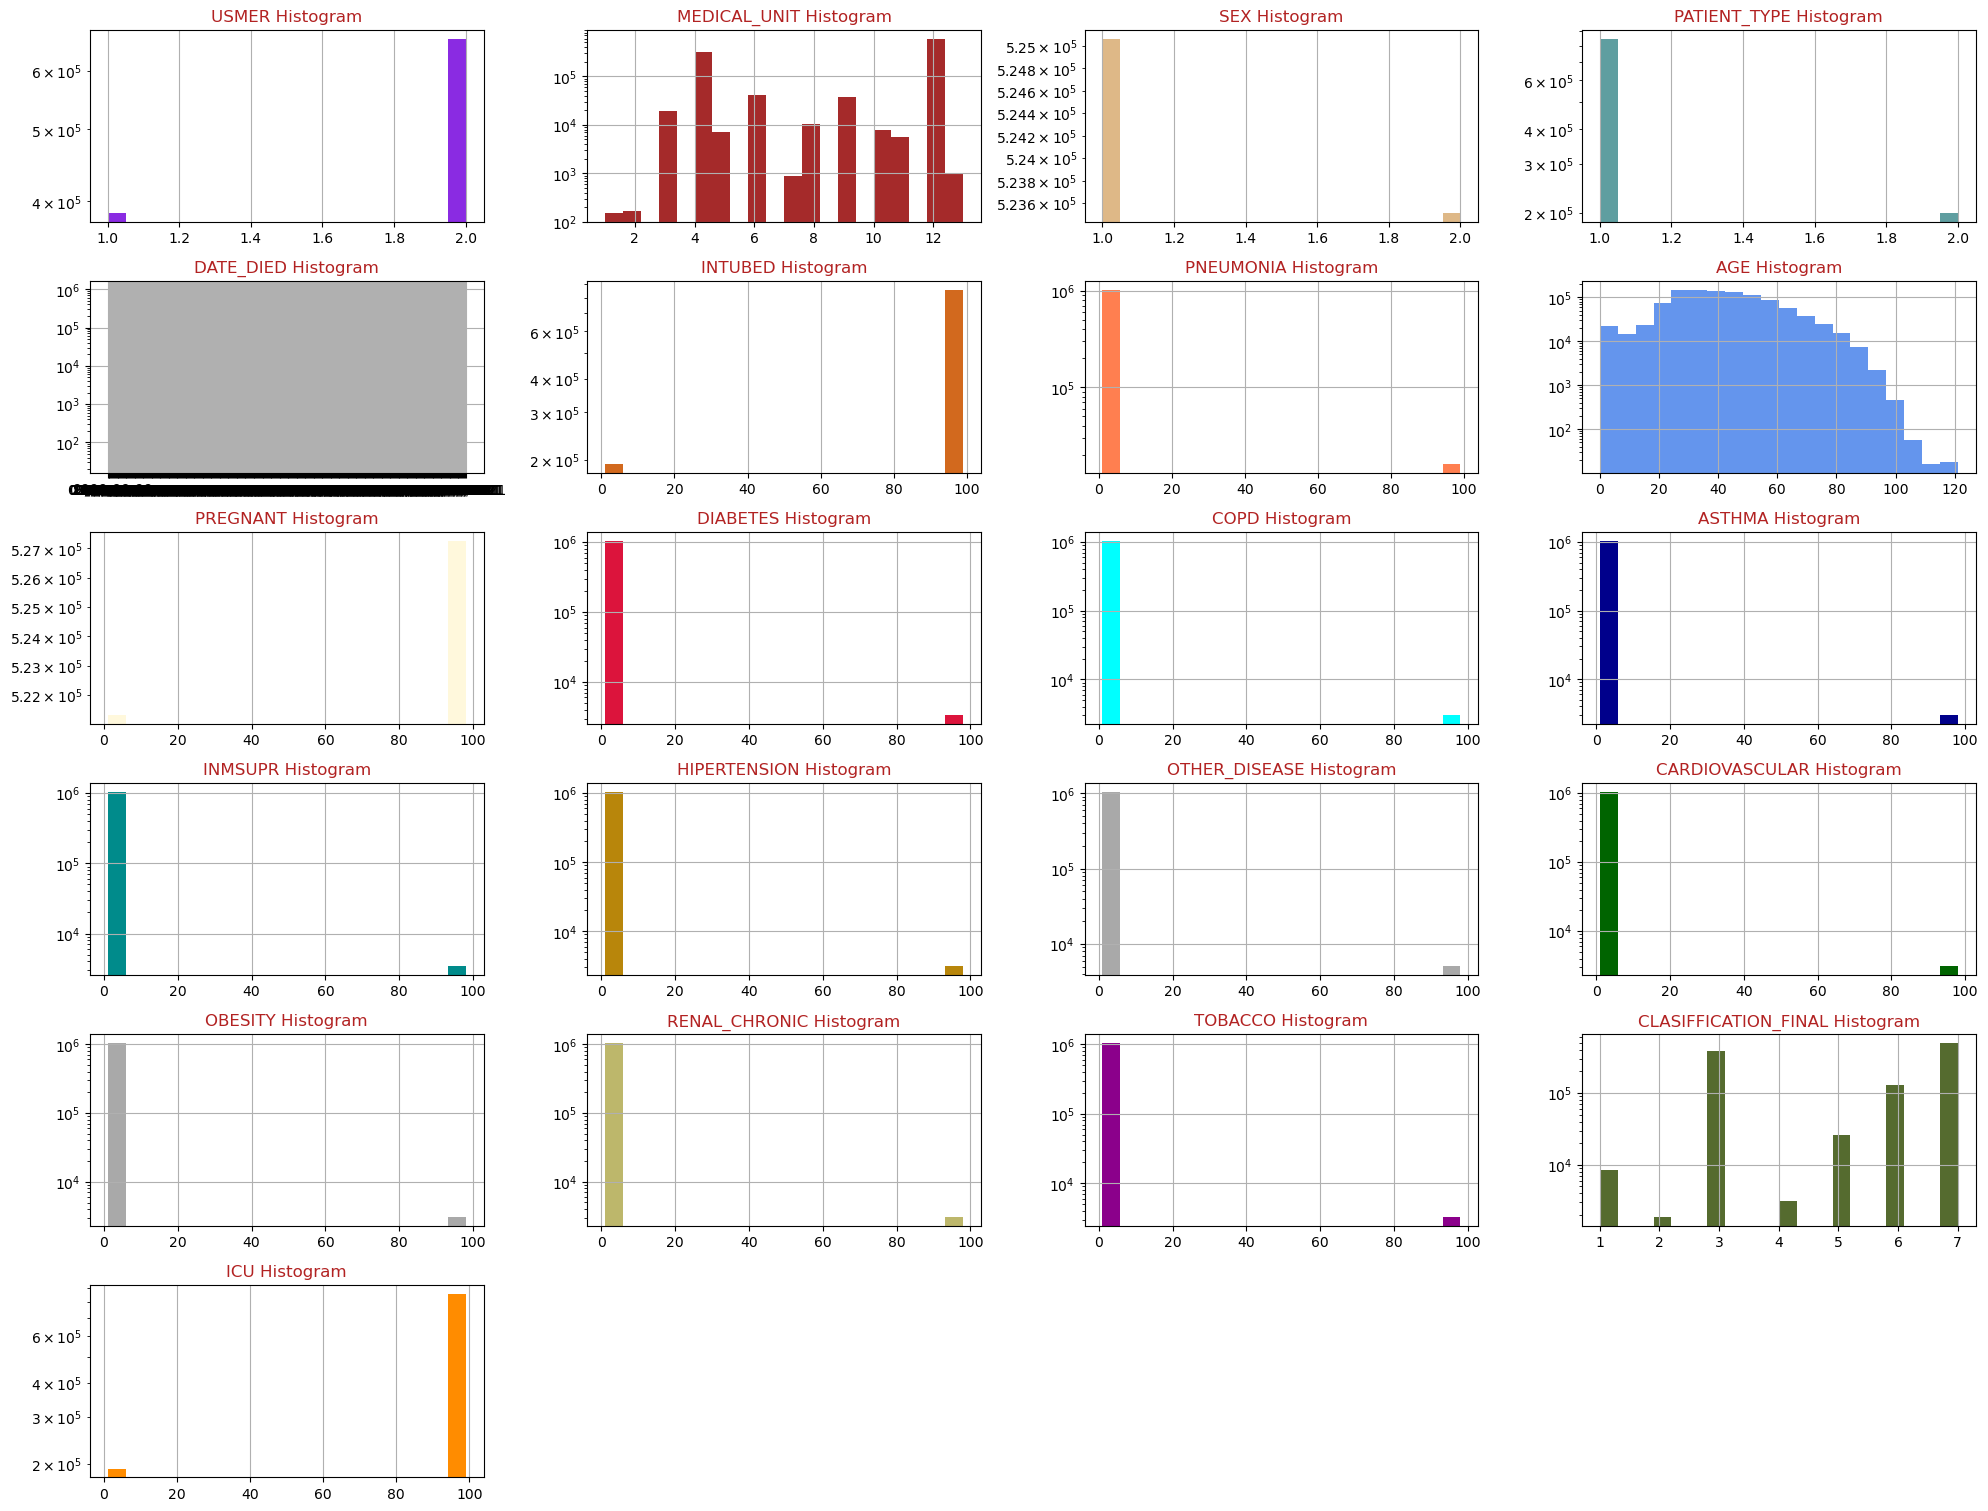

In [59]:
# Display historgram for class 1 accidents
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

### Histogram of 'alive' cases

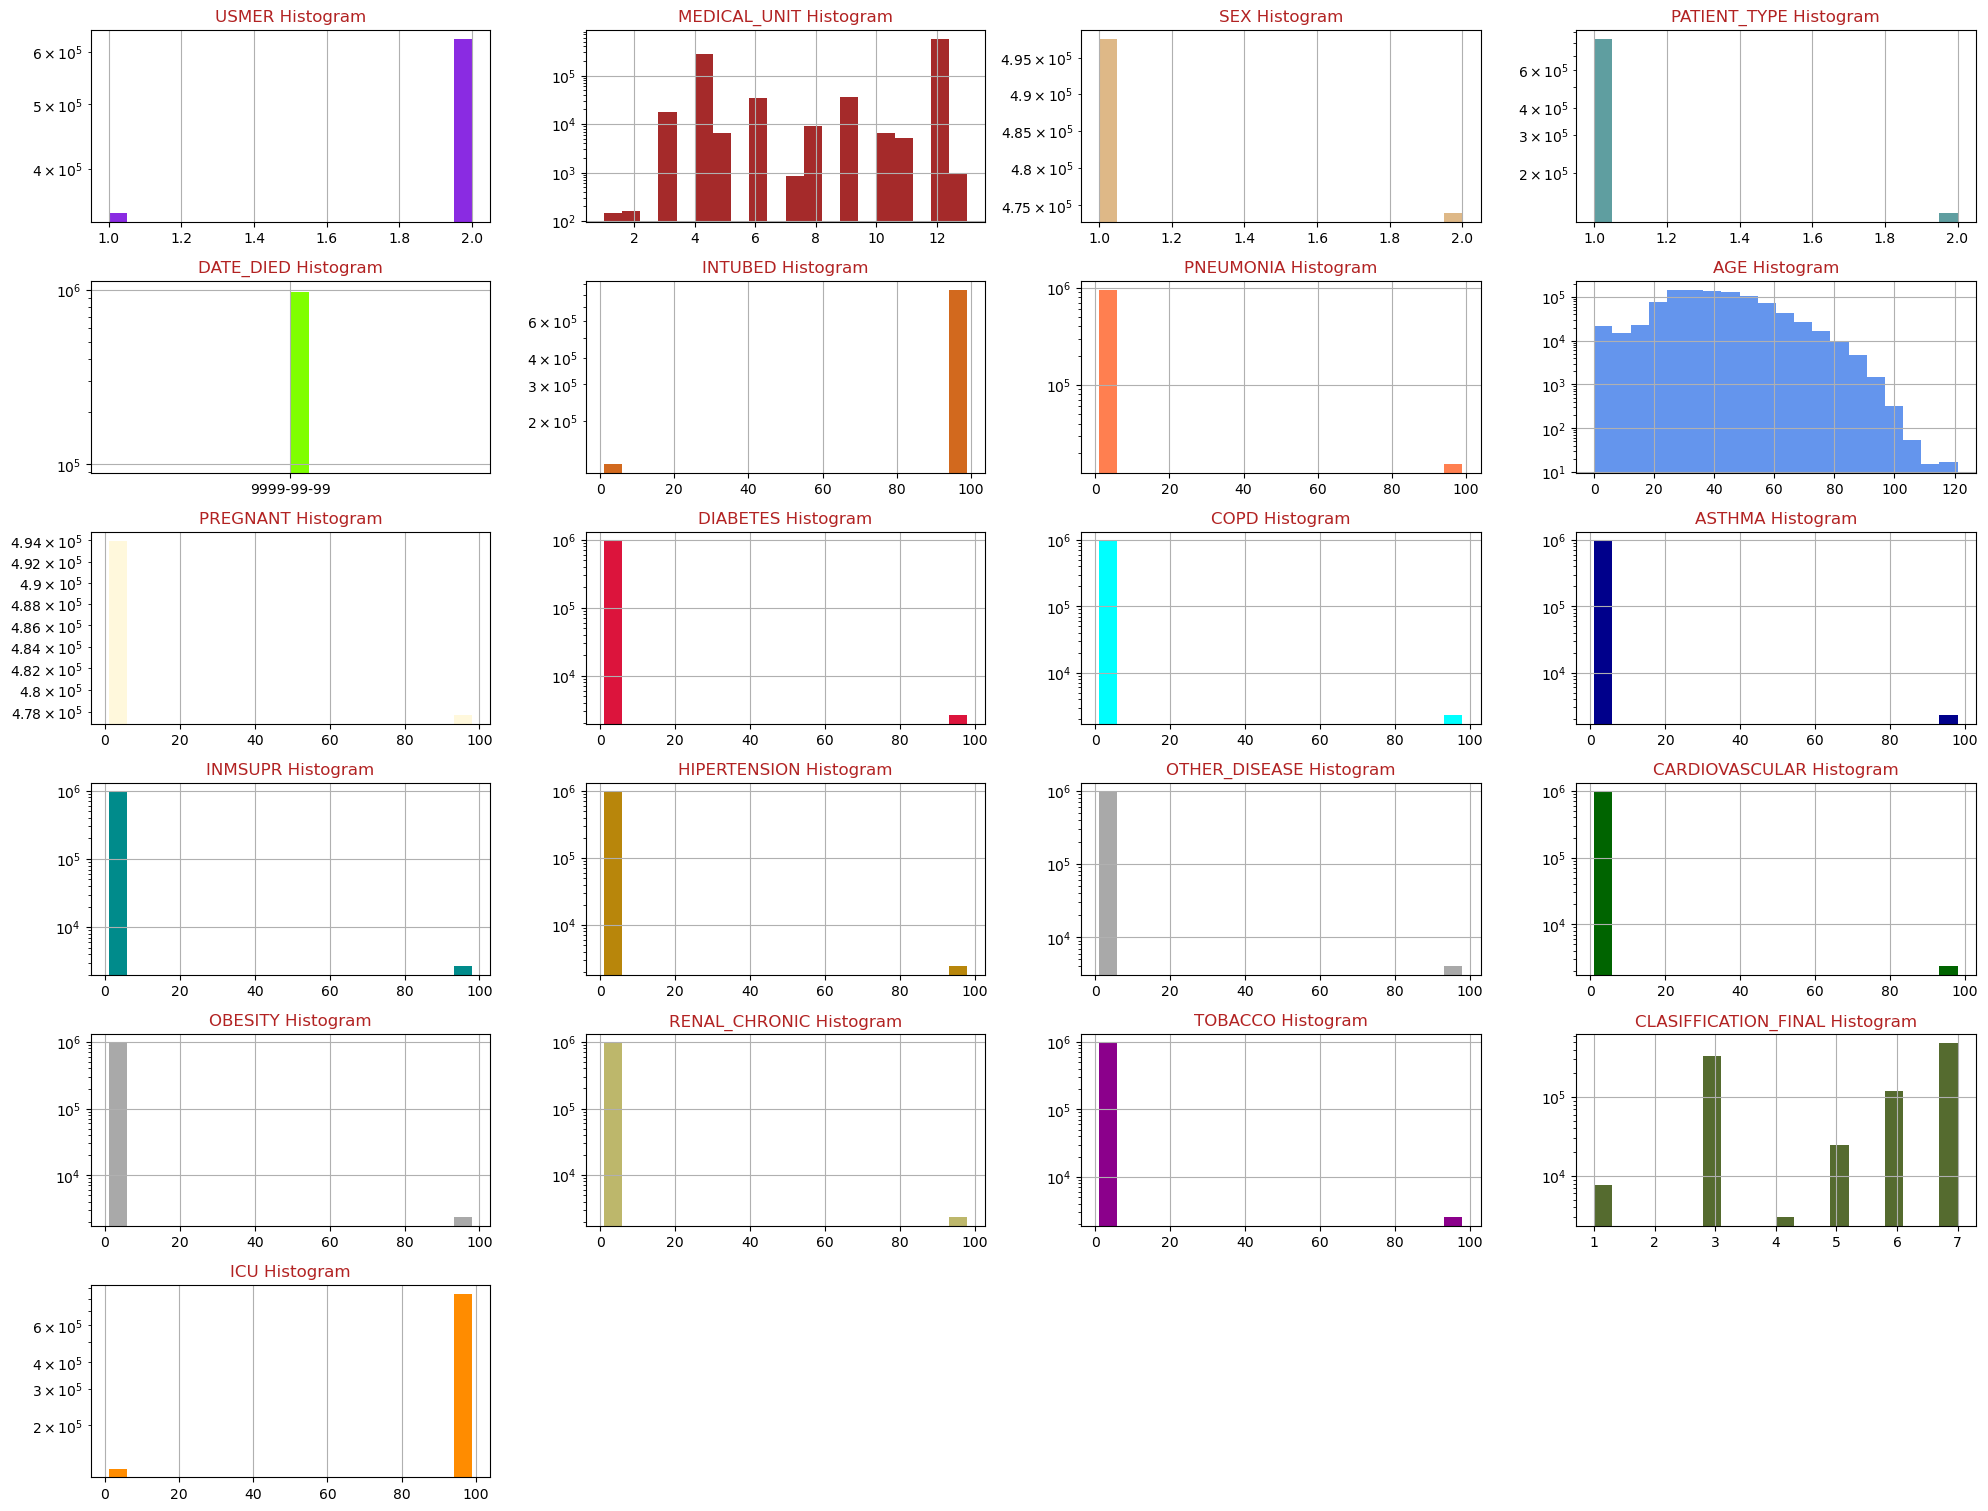

In [60]:
df_alive = df.loc[df['DATE_DIED']=='9999-99-99']

# Display historgram for class 1 accidents
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df_alive.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df_alive[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

In [61]:
df_alive.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
7,2,1,1,1,9999-99-99,97,1,64,2,1,...,2,1,1,2,2,2,1,2,3,97
8,2,1,1,2,9999-99-99,2,2,37,2,1,...,2,2,1,2,2,1,2,2,3,2
9,2,1,1,2,9999-99-99,2,2,25,2,2,...,2,2,2,2,2,2,2,2,3,2


### Histogram of 'dead' cases

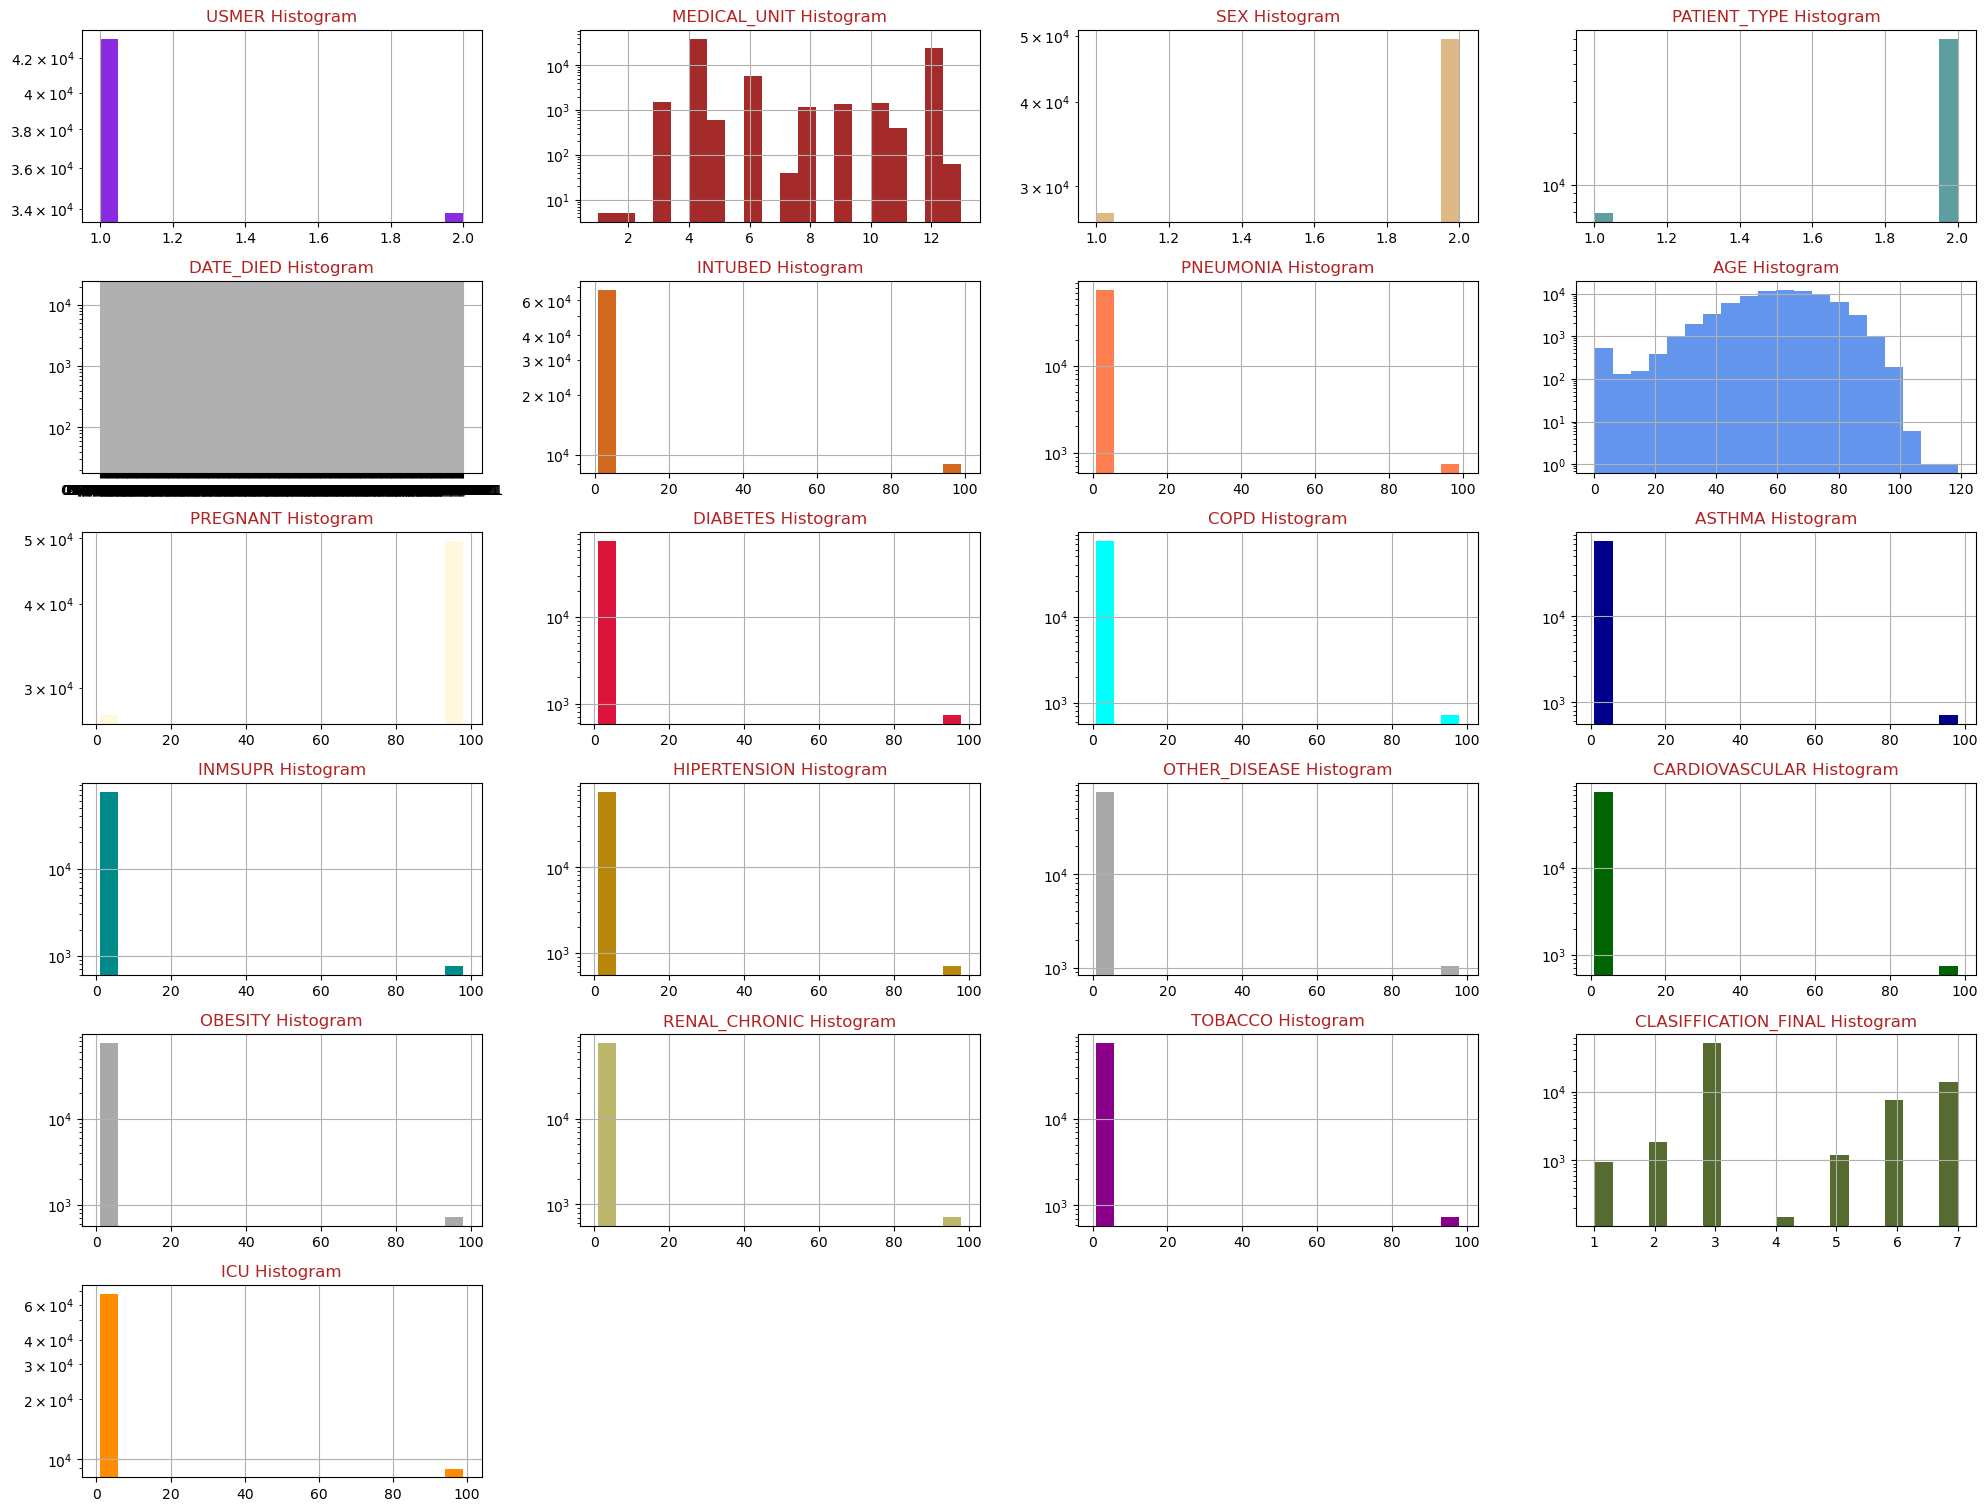

In [62]:
df_dead = df.loc[df['DATE_DIED']!='9999-99-99']

# Display historgram for class 1 accidents
colors = list(mcolors.CSS4_COLORS.keys())[10:]
fig = plt.figure(figsize=(20,20))
for i, feature in enumerate(df_dead.columns):
    f = fig.add_subplot(8, 4, i + 1)
    df_dead[feature].hist(bins = 20, ax = f, facecolor = colors[i])
    f.set_title(feature + " Histogram", color = colors[35])
    f.set_yscale('log')
fig.tight_layout()
plt.show()

In [63]:
df_dead.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


### Heatmap correlation

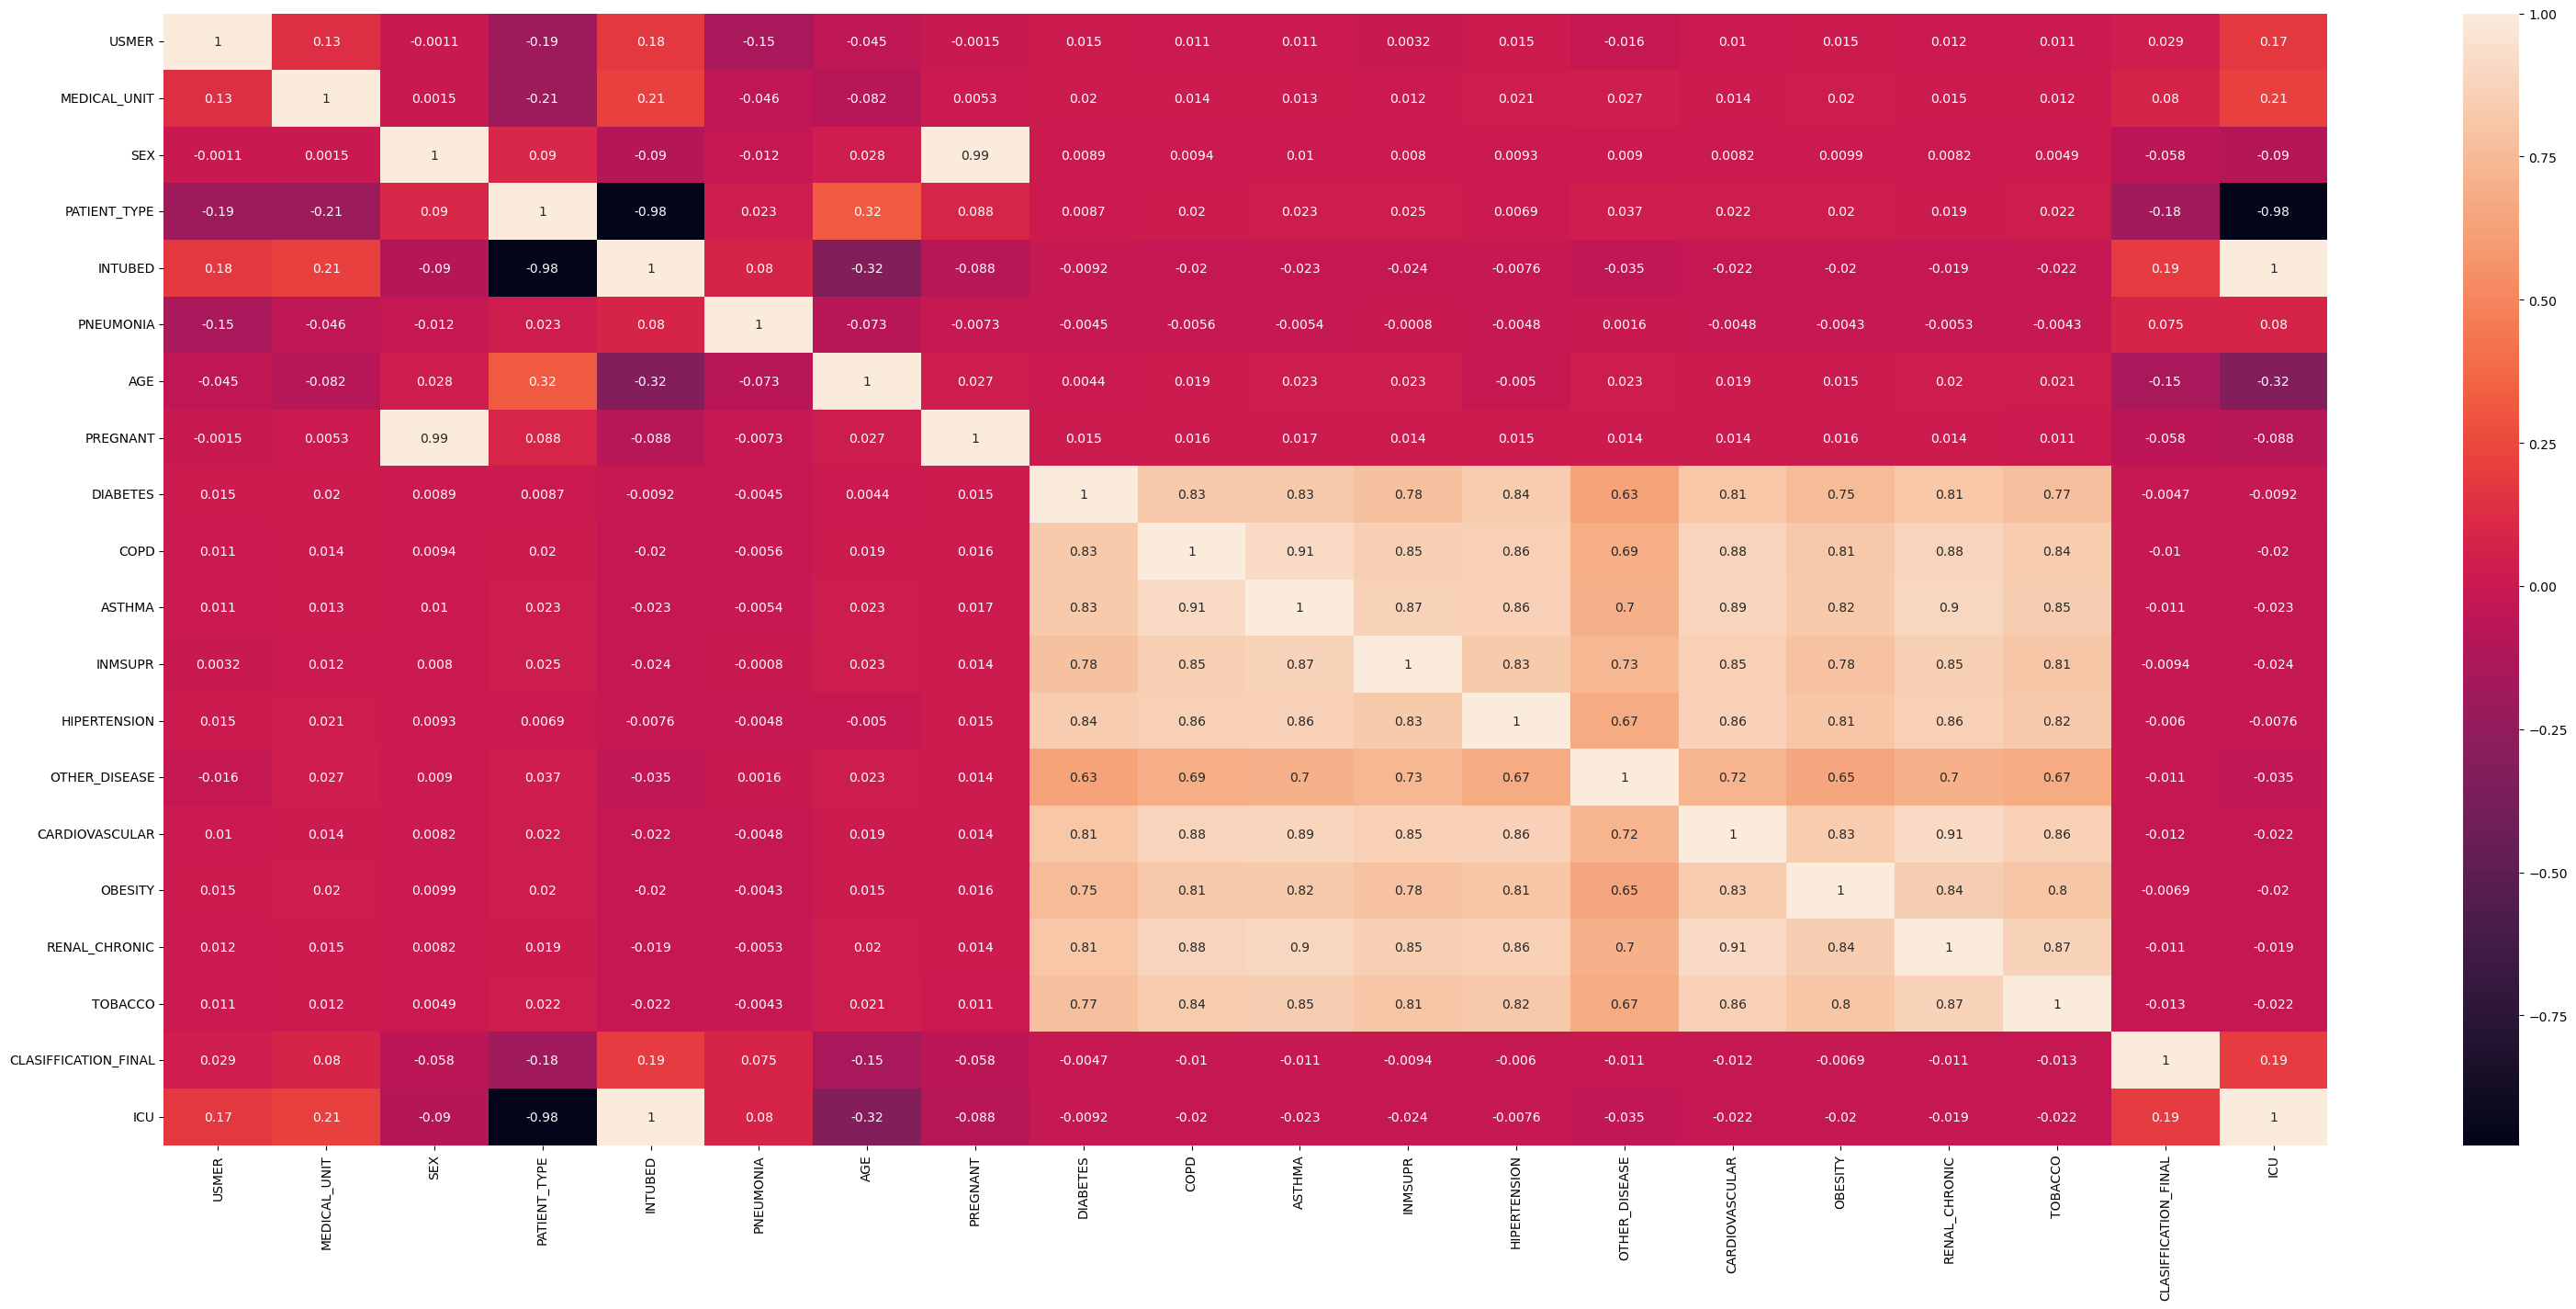

In [79]:
# Heatmap
plt.figure(figsize = (38, 16))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Preliminary Analysis

There are quite a few differences between 'alive' and 'dead' cases...

---

## Logistic Regression

A logistic regression was created rather than a linear regression as this model attempts to classify cases between binary values of 'alive' or 'dead'.

---

In [113]:
# Rebuild dataframe to contain binary values for 'ALIVE/DEAD' status
# Alive - 0
# Dead - 1
df = pd.read_csv('Covid Data.csv')
df = df.rename(columns={'DATE_DIED':'ALIVE_DEAD'})
df.loc[df['ALIVE_DEAD'] != '9999-99-99', 'ALIVE_DEAD'] = 1
df.loc[df['ALIVE_DEAD'] == '9999-99-99', 'ALIVE_DEAD'] = 0
df['ALIVE_DEAD'] = df['ALIVE_DEAD'].astype(np.int64)

In [114]:
# Create training and testing set
df_y = df['ALIVE_DEAD']
df_x = df.iloc[:, df.columns!='ALIVE_DEAD']
df_x = scale(df_x)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=12, stratify=df_y)

In [96]:
# Create and test Logistic Regression Model
model = LogisticRegression();
model.fit(x_train, y_train)
train_accuracy = model.score(x_train, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(x_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 93.58%
The accuracy for the test set is 93.65%


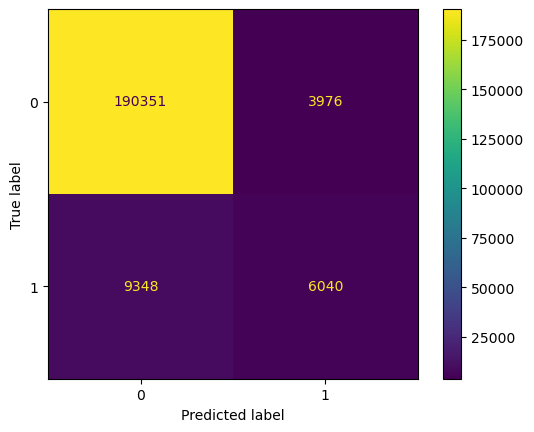

In [97]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [98]:
df

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,ALIVE_DEAD,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,1,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,1,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,1,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,1,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,1,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,0,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,0,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,0,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,0,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [100]:
# Preliminary Values
print('Number of cases:', len(df.index))
print('Number of cases alive:', sum(df['ALIVE_DEAD']==0))
print('Number of cases dead:', sum(df['ALIVE_DEAD']==1))

Number of cases: 1048575
Number of cases alive: 971633
Number of cases dead: 76942


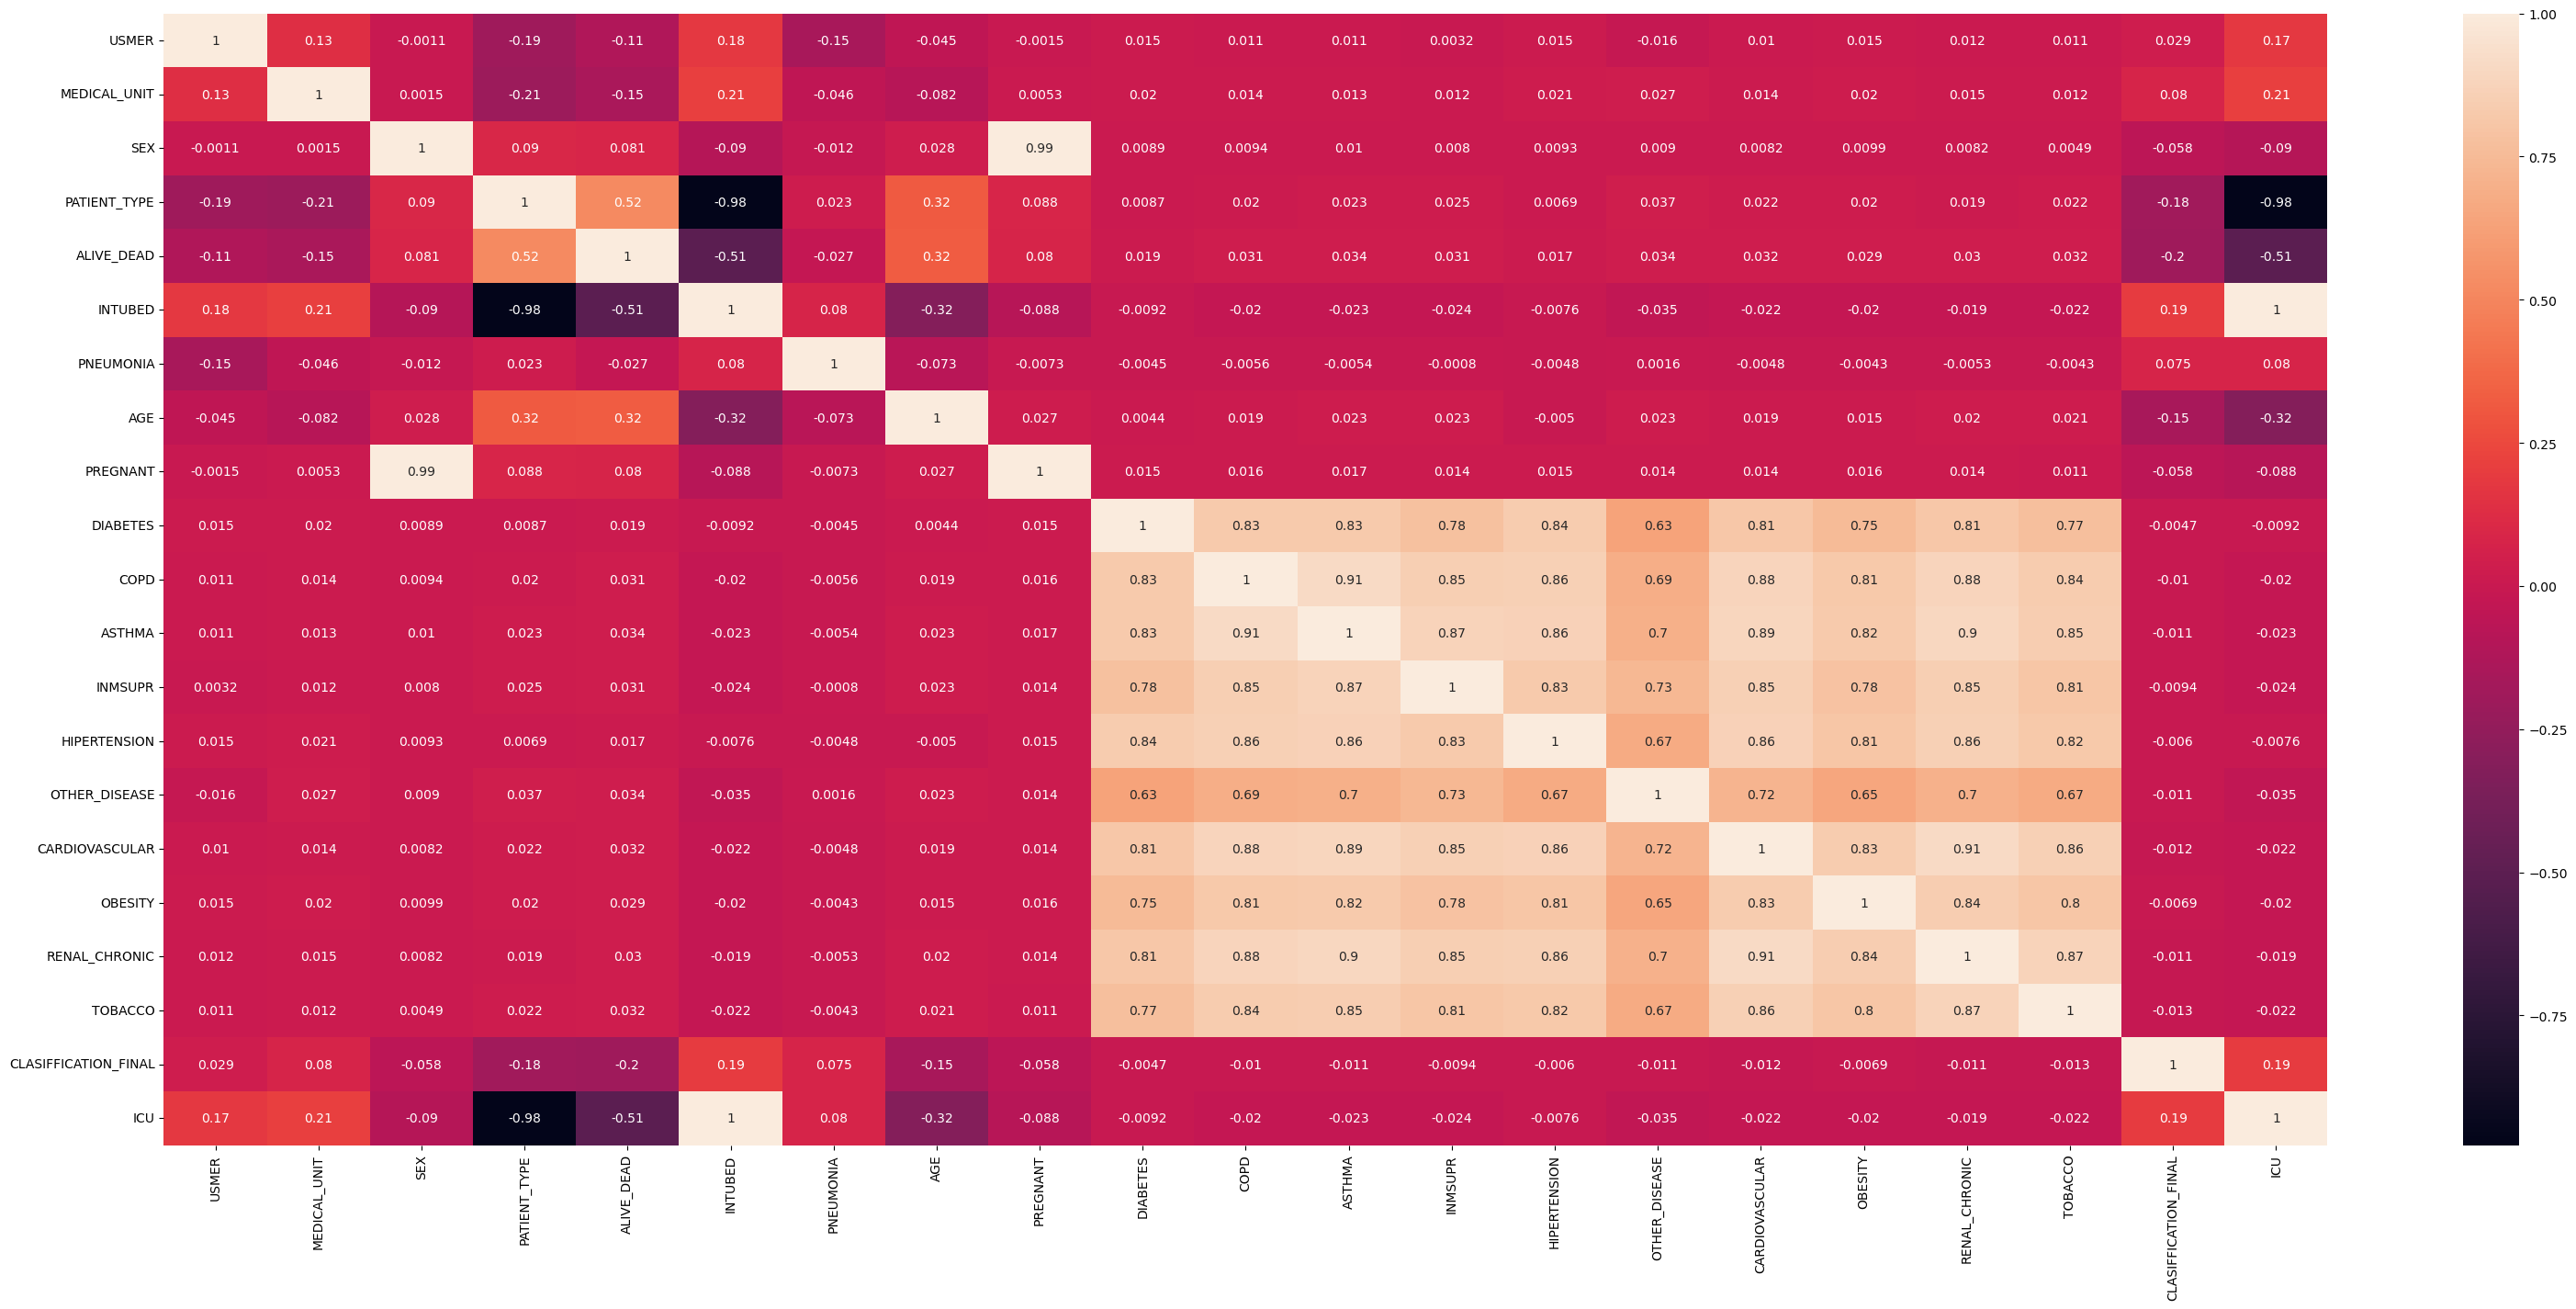

In [99]:
# Heatmap
plt.figure(figsize = (38, 16))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Heatmap Analysis

Things that correlated high with ALIVE_DEAD are PATIENT_TYPE, INTUBED, AGE, CLASSIFICATION_FINAL, ICU

### Optimized Logistic Regression

In [101]:
# Rebuild dataframe to contain binary values for 'ALIVE/DEAD' status
# Alive - 0
# Dead - 1
df = pd.read_csv('Covid Data.csv')
df = df.rename(columns={'DATE_DIED':'ALIVE_DEAD'})
df.loc[df['ALIVE_DEAD'] != '9999-99-99', 'ALIVE_DEAD'] = 1
df.loc[df['ALIVE_DEAD'] == '9999-99-99', 'ALIVE_DEAD'] = 0
df['ALIVE_DEAD'] = df['ALIVE_DEAD'].astype(np.int64)

In [111]:
# Create training and testing set
df_y = df['ALIVE_DEAD']
df_x = df.filter(['PATIENT_TYPE', 'INTUBED', 'AGE', 'CLASSIFICATION_FINAL', 'ICU'], axis=1)
df_x = scale(df_x)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.20, random_state=12, stratify=df_y)
df_x

array([[-0.48552486,  0.47403474,  1.37253057,  0.47377997],
       [-0.48552486,  0.47403474,  1.78655093,  0.47377997],
       [ 2.05962678, -2.12978803,  0.78107292, -2.10612542],
       ...,
       [-0.48552486,  0.47403474,  0.78107292,  0.47377997],
       [-0.48552486,  0.47403474, -0.81586275,  0.47377997],
       [-0.48552486,  0.47403474,  0.60363562,  0.47377997]])

In [105]:
# Create and test Logistic Regression Model
model = LogisticRegression();
model.fit(x_train, y_train)
train_accuracy = model.score(x_train, y_train)
print(f'The accuracy for the training set is {100 * train_accuracy:.2f}%')
test_accuracy = model.score(x_test, y_test)
print(f'The accuracy for the test set is {100 * test_accuracy:.2f}%')

The accuracy for the training set is 92.93%
The accuracy for the test set is 92.97%


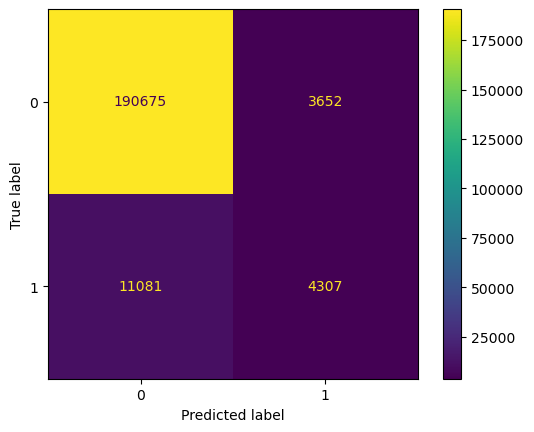

In [106]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()